# Problem 5: Number Factoring

solver: 房伯文

### (a) Matrices expression

In [79]:
import sympy as sp

p1, p2 = sp.symbols('p1 p2')
q1, q2 = sp.symbols('q1 q2')
w11, w12, w21, w22 = sp.symbols('w11 w12 w21 w22')
z12, z23, z24, z34, z45 = sp.symbols('z12 z23 z24 z34 z45')

x = sp.Matrix([p1, p2, q1, q2, z12, z23, z24, z34, z45, w11, w12, w21, w22])

def g(x, y, z):
    return x*y - 2*x*z - 2*y*z + 3*z

def f(x):
    return (x+1)/2

In [80]:
N = 35
n = []
for i in range(6):
    n.append((N >> i) & 1)
print(n)

expr = (n[1] + 2*f(z12) - f(p1) - f(q1))**2 \
    + (n[2] + 2*f(z23) + 4*f(z24) - f(z12) - f(p2) - f(q2) - f(w11))**2 \
    + (n[3] + 2*f(z34) - f(z23) - f(w12) - f(w21))**2 \
    + (n[4] + 2*f(z45) - f(z24) - f(z34) - f(w22))**2 \
    + (n[5] - f(z45))**2 \
    + g(f(p1), f(q1), f(w11)) + g(f(p1), f(q2), f(w12)) + g(f(p2), f(q1), f(w21)) + g(f(p2), f(q2), f(w22))

[1, 1, 0, 0, 0, 1]


In [81]:
from sympy import latex
from IPython.display import Math, display
Q = sp.hessian(expr, x)
# print(Q)
# sp.pprint(Q)

J = -sp.Matrix(Q.rows, Q.cols, lambda i, j: Q[i, j] if i < j else 0)
print("The Matrix J is: ")
display(Math(latex(J)))
# sp.pprint(J)

tr = Q.trace() / 2  # The const generated by s_i^2 terms.
# print(tr)

grad = sp.Matrix([sp.diff(expr, var) for var in x])
h = -(grad - Q * x)
print("The Vector h is: ")
display(Math(latex(h)))
# sp.pprint(h)

# const = expr - (0.5 * x.T * Q * x + h.T * x)[0]
const = expr.subs({var: 0 for var in x}) + tr
print("The constant term is: ")
print(const)

The Matrix J is: 


<IPython.core.display.Math object>

The Vector h is: 


<IPython.core.display.Math object>

The constant term is: 
17


### (b) Brute force method

In [82]:
import numpy as np
from itertools import product

h_np = np.array(h, dtype=float).flatten()
J_np = np.array(J, dtype=float)
const_float = float(const)

num_vars = len(x)
states = list(product([-1, 1], repeat=num_vars))

min_energy = None
ground_states = []

for state in states:
    s = np.array(state, dtype=float)
    
    # Ising energy: E = -h·s - sum(J_ij s_i s_j) + const
    energy = -np.dot(h_np, s) - np.sum(J_np * np.outer(s, s)) + const_float

    if min_energy is None or energy < min_energy - 1e-9:
        min_energy = energy
        ground_states = [state]
    elif abs(energy - min_energy) < 1e-9:
        ground_states.append(state)

print("Min energy =", min_energy)
print("Ground states =", ground_states)

Min energy = 0.0
Ground states = [(-1, 1, 1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1), (1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1)]


In [83]:
from itertools import product

# use `product` to iterate through all the possibilities
num_vars = len(x)
states = list(product([-1,1], repeat=num_vars))

min_energy = None
ground_states = []

for state in states:
    subs_dict = dict(zip(x, state))
    energy = expr.subs(subs_dict).evalf()
    if min_energy is None or energy < min_energy:
        min_energy = energy
        ground_states = [state]
    elif energy == min_energy:
        ground_states.append(state)

print("The ground state energy is: ", min_energy)
print("The ground states are: ", ground_states)


The ground state energy is:  0
The ground states are:  [(-1, 1, 1, 1, -1, 1, -1, 1, 1, -1, -1, 1, 1), (1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1)]


### (c) Quantum annealing method

In [84]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter

T = 10.0
M = 100
dt = T / M
B0 = 1.0

def Hamiltonian(h, J, const):
    pauli_list = []
    coeffs = []

    for i in range(num_vars):
        if h[i] != 0:
            s = ['I'] * num_vars
            s[i] = 'Z'
            pauli_list.append(''.join(s))
            coeffs.append(h[i])
    
    for i in range(num_vars):
        for j in range(i+1, num_vars):
            if J[i,j] != 0:
                s = ['I'] * num_vars
                s[i] = 'Z'
                s[j] = 'Z'
                pauli_list.append(''.join(s))
                coeffs.append(J[i,j])
    
    if const != 0:
        pauli_list.append('I'*num_vars)
        coeffs.append(const)
    
    # for i in range(num_vars):
    #     s = ['I'] * num_vars
    #     s[i] = 'X'
    #     pauli_list.append(''.join(s))
    #     coeffs.append(B0)
    
    H = SparsePauliOp(pauli_list, coeffs)
    return H

H_problem = Hamiltonian(-h, -J, const)

paulis = ['I'*i + 'X' + 'I'*(num_vars-i-1) for i in range(num_vars)]
coeffs = [-B0]*num_vars
Hmixer = SparsePauliOp(paulis, coeffs)

circ = QuantumCircuit(num_vars)

for i in range(num_vars):
    circ.h(i)

# 离散演化
for step in range(M):
    t = step / M
    H_t = (1-t) * Hmixer + t * H_problem
    U_t = PauliEvolutionGate(H_t, dt)
    st = SuzukiTrotter(order=2, reps=1)
    circ.append(st.synthesize(U_t), range(num_vars))

# U = PauliEvolutionGate(H, T)
# st = SuzukiTrotter(order=2, reps=M)
# circ = st.synthesize(U)
circ.save_statevector(label="psi")

Statevector([ 0.00189946+6.90364808e-04j, -0.00300311-3.83064915e-03j,
             -0.00025902-1.71495800e-05j, ...,  0.00064368-3.97628820e-05j,
             -0.0015955 +9.10888084e-04j, -0.00593908-8.03794772e-02j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2))
The ground states are:  ['1101010110101', '0111010110011']


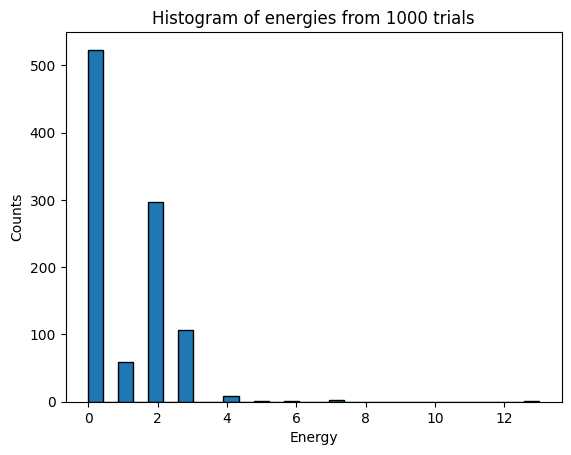

In [85]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit_aer import AerSimulator
from qiskit import transpile


# circ_no_meas = circ.remove_final_measurements()
sim = AerSimulator(method='statevector')
circ_t = transpile(circ, sim)

result = sim.run(circ_t).result()
state = result.data()['psi']
print(state)

num_trials = 1000
probs = np.abs(state)**2
all_states = [np.binary_repr(i, width=num_vars) for i in range(2**num_vars)]
samples = np.random.choice(all_states, size=num_trials, p=probs)
# print(samples[0].shape())

# Max probable state
max_prob = np.max(probs)
max_indices = np.where(probs >= 0.9 * max_prob)[0]
best_states = [np.binary_repr(idx, width=num_vars) for idx in max_indices]
corrected_states = [
    ''.join('1' if b=='0' else '0' for b in s)
    for s in best_states
]
print("The ground states are: ", corrected_states)

def compute_energy(bitstring, h, J, const):
    s = np.array([1 if b=='0' else -1 for b in bitstring])
    energy = -np.dot(h_np, s) + -np.sum(J_np * np.outer(s, s)) + const
    return energy

energies = [compute_energy(s, h, J, const) for s in samples]
energies = [float(e) for e in energies]

plt.hist(energies, bins=30, edgecolor='k')
plt.xlabel("Energy")
plt.ylabel("Counts")
plt.title("Histogram of energies from 1000 trials")
plt.show()

### (d) N=27

Just use `N=27` to rerun the code, we will get the result
```
The ground states are:  ['1101010000001', '0111010000001', '0101010000001']
```
This means that it has been factored to `5*7`, `7*5`, `5*5`.